# First-time Home Buyers Dataset Analysis

Import packages and read original dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

In [2]:
df=pd.read_csv(r'C:\Users\linhv\.spyder-py3\mortgages-in-ny-ne-clean.csv')

print(df.info())

C:\Users\linhv\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (45) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1063316 entries, 0 to 1063315
Columns: 101 entries, Unnamed: 0 to tract_median_age_of_housing_units
dtypes: float64(44), int64(43), object(14)
memory usage: 819.4+ MB
None


Clean data

In [3]:
# drop redundant columns
df.drop(['Unnamed: 0', 'Unnamed: 0.1', 'activity_year'], inplace=True, axis=1)

# add column for 'approved' or 'denied' status
def loan_status (row):
    if (row.action_taken == 1) | (row.action_taken == 6) | (row.action_taken == 2) | (row.action_taken == 8):
        return 'Approved'
    if (row.action_taken == 3) | (row.action_taken == 7):
        return 'Denied'
df['loan_status']=df.apply(loan_status,axis=1) 

# make loan_amount in thousands of dollars unit to be consistent with income unit
df['loan_amount'] = df['loan_amount']/1000

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1063316 entries, 0 to 1063315
Data columns (total 99 columns):
lei                                         1063316 non-null object
derived_msa_md                              1063316 non-null int64
state_code                                  1063316 non-null object
county_code                                 1057044 non-null float64
census_tract                                1056300 non-null float64
conforming_loan_limit                       1053335 non-null object
derived_loan_product_type                   1063316 non-null object
derived_dwelling_category                   1063316 non-null object
derived_ethnicity                           1063316 non-null object
derived_race                                1063316 non-null object
derived_sex                                 1063316 non-null object
action_taken                                1063316 non-null int64
purchaser_type                              1063316 non-null int64
prea

Filter first-time home buyers subset

In [4]:
'''filter subset for first-time home buyers'''

subset = df[(df.loan_purpose == 1) #keep "Home Purchase" for loan purpose
        & (df.business_or_commercial_purpose != 1) #remove business/commercial purpose
        & (df.occupancy_type == 1) #keep only "principal residence" 
        & (df.applicant_age_above_62 != 'Yes') 
        & (df.co_applicant_age_above_62 != 'Yes')
        & (df.reverse_mortgage != 1) #remove those qualifies for reverse mortgage
        ]

# exclude outliers in income and loan_amount columns
subset=subset[(subset.income.between(0, 15000)) & (subset.loan_amount <= 15000)]

print(subset.shape)
print(subset.info())

(349093, 99)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 349093 entries, 0 to 1063315
Data columns (total 99 columns):
lei                                         349093 non-null object
derived_msa_md                              349093 non-null int64
state_code                                  349093 non-null object
county_code                                 346597 non-null float64
census_tract                                346032 non-null float64
conforming_loan_limit                       349079 non-null object
derived_loan_product_type                   349093 non-null object
derived_dwelling_category                   349093 non-null object
derived_ethnicity                           349093 non-null object
derived_race                                349093 non-null object
derived_sex                                 349093 non-null object
action_taken                                349093 non-null int64
purchaser_type                              349093 non-null int64
preap

In [5]:
sns.set(style='darkgrid', font_scale=1.3) #set overall graph style

First-time home buyers demographics

In [6]:
# age
age=pd.DataFrame(subset.applicant_age.value_counts())
age=age.reindex(['<25','25-34','35-44','45-54','55-64','8888'])
age.columns=['Applications']
age['Median income']=subset.groupby('applicant_age')['income'].median()
age['Median loan_amount']=subset.groupby('applicant_age')['loan_amount'].median()
age['Median interest rate']=subset.groupby('applicant_age')['interest_rate'].median()
age=age.rename(index={'8888': 'No info'})
print(age)

         Applications  Median income  Median loan_amount  Median interest rate
<25             14973           58.0               155.0                 4.625
25-34          128840           86.0               255.0                 4.625
35-44          102226          105.0               305.0                 4.625
45-54           63916           98.0               265.0                 4.625
55-64           29127           91.0               225.0                 4.625
No info         10011           90.0               265.0                 4.500


In [7]:
# sex
sex=pd.DataFrame(subset.derived_sex.value_counts())
sex.columns=['Applications']
sex['Median income']=subset.groupby('derived_sex')['income'].median()
sex['Median loan_amount']=subset.groupby('derived_sex')['loan_amount'].median()
sex['Median interest rate']=subset.groupby('derived_sex')['interest_rate'].median()
print(sex)

                   Applications  Median income  Median loan_amount  \
Joint                    125122          121.0               315.0   
Male                     114230           80.0               245.0   
Female                    77370           71.0               205.0   
Sex Not Available         32371          101.0               285.0   

                   Median interest rate  
Joint                             4.625  
Male                              4.625  
Female                            4.625  
Sex Not Available                 4.580  


In [8]:
# race
race=pd.DataFrame(subset.derived_race.value_counts())
race.columns=['Applications']
race['Median income']=subset.groupby('derived_race')['income'].median()
race['Median loan_amount']=subset.groupby('derived_race')['loan_amount'].median()
race['Median interest rate']=subset.groupby('derived_race')['interest_rate'].median()
race=race.reindex(['American Indian or Alaska Native','Asian','Black or African American',
                 'Native Hawaiian or Other Pacific Islander','White','2 or more minority races',
                 'Joint','Free Form Text Only','Race Not Available'])
print(race)

                                           Applications  Median income  \
American Indian or Alaska Native                    805           70.0   
Asian                                             28084          104.0   
Black or African American                         18552           84.0   
Native Hawaiian or Other Pacific Islander           638           79.5   
White                                            243996           90.0   
2 or more minority races                            416           81.0   
Joint                                              6575          132.0   
Free Form Text Only                                  31           79.0   
Race Not Available                                49996          100.0   

                                           Median loan_amount  \
American Indian or Alaska Native                        185.0   
Asian                                                   375.0   
Black or African American                               285.0   

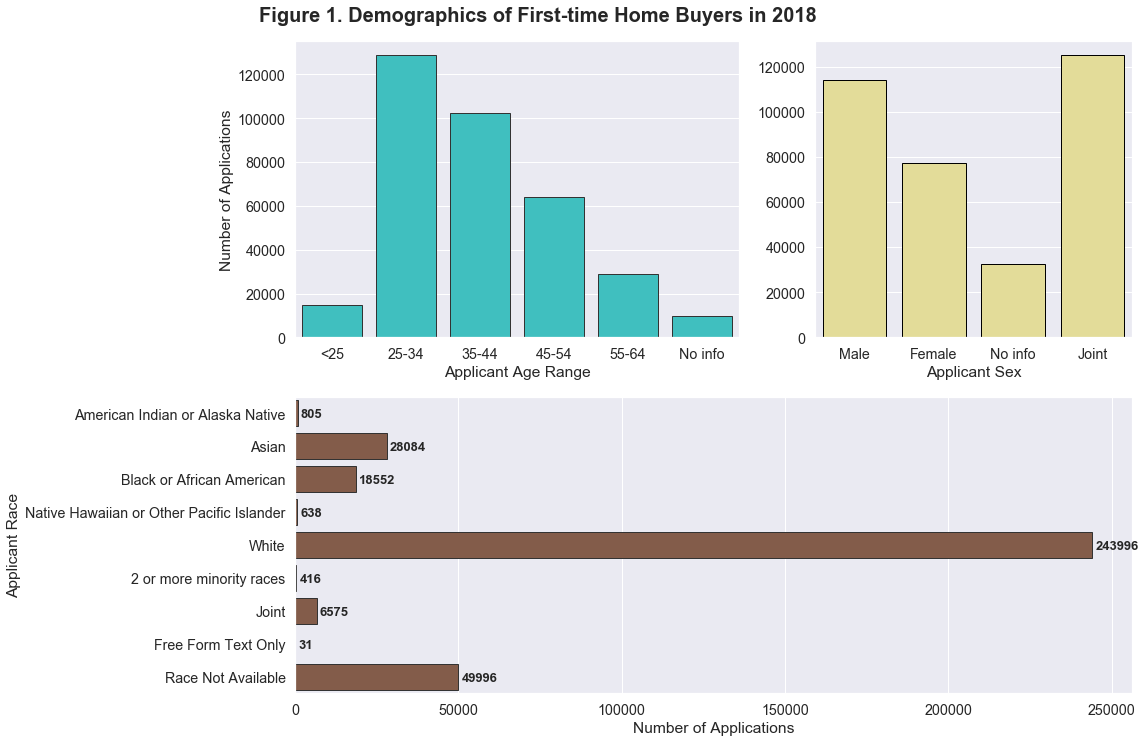

In [9]:
# subplots for demographics graphs
gs=gridspec.GridSpec(2,2,width_ratios=[1.4,1])
fig= plt.figure(figsize=(15,12))

# age bar chart
ax=plt.subplot(gs[0,0])
age_fig=sns.barplot(x=age.index, y='Applications', data=age, color='cyan',
                      saturation=.5, edgecolor='.2')
age_fig.set(ylabel='Number of Applications', xlabel='Applicant Age Range')
fig.suptitle('Figure 1. Demographics of First-time Home Buyers in 2018',
          ha='center', weight='bold', fontsize=20, x=.35, y=.92)

# sex bar chart
ax=plt.subplot(gs[0,1])
sex_fig=sns.countplot(x='derived_sex', data=subset, color='khaki', 
                      edgecolor='black')
sex_fig.set_xticklabels(['Male','Female','No info','Joint'])
sex_fig.set(xlabel='Applicant Sex', ylabel='')

# race bar chart
ax=plt.subplot(gs[1,:])
race_fig=sns.barplot(y=race.index, x='Applications', data=race, color='sienna',
                      saturation=.5, edgecolor='.2')
race_fig.set(xlabel='Number of Applications', ylabel='Applicant Race')
for i in race_fig.patches:
    race_fig.text(i.get_width()+1000, i.get_y()+0.52, str(int(i.get_width())),
                  fontweight='bold', fontsize=13)                 
plt.show()

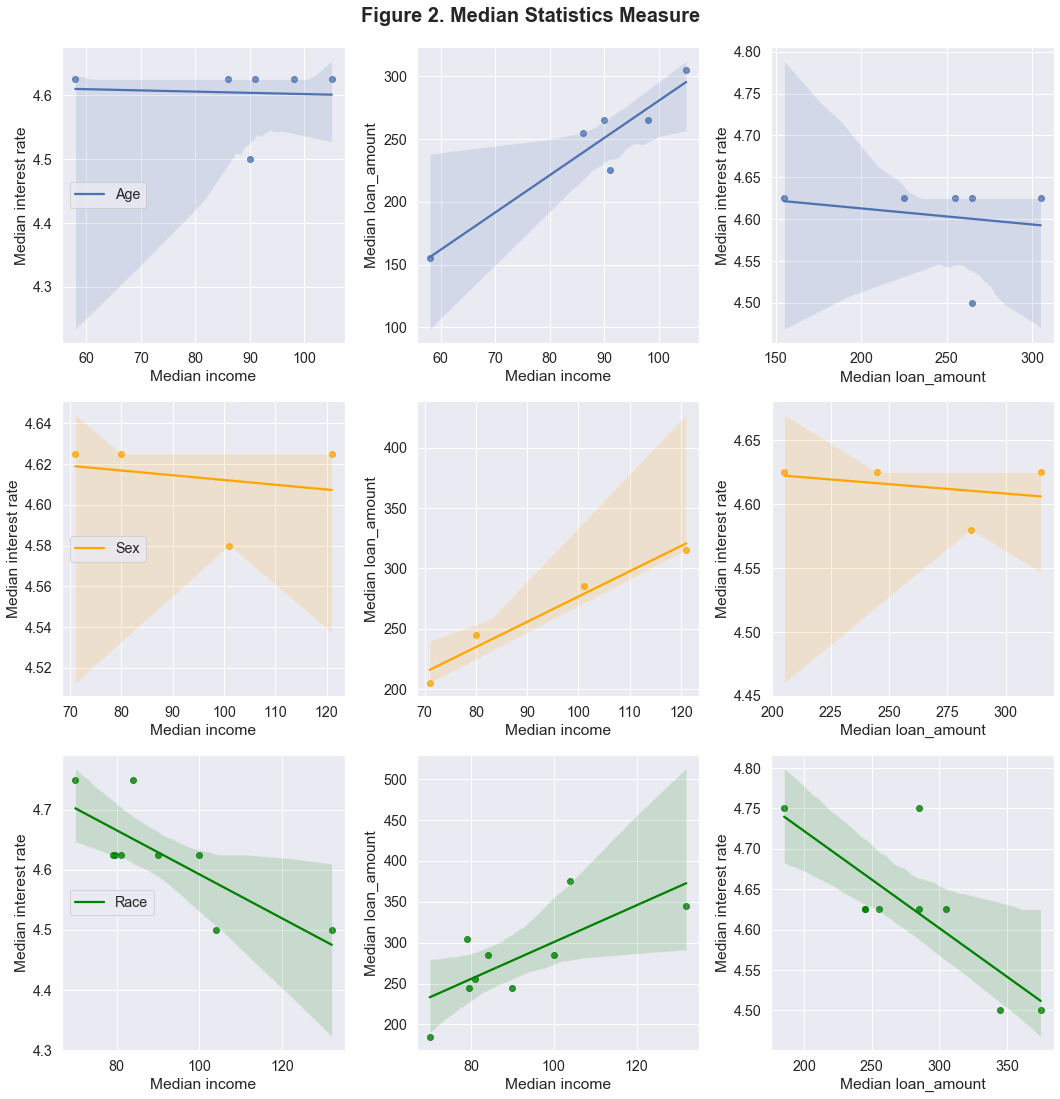

In [10]:
# regression plots for relationships among income, loan amount, interest rate
fig, ax = plt.subplots(3,3,figsize=(15,15))
fig.suptitle('Figure 2. Median Statistics Measure', x=.5, y=1.02,fontsize=20, fontweight='bold')
age1=sns.regplot(data=age, x='Median income',y='Median interest rate', ax=ax[0,0])
age2=sns.regplot(data=age, x='Median income',y='Median loan_amount', ax=ax[0,1])
age3=sns.regplot(data=age, x='Median loan_amount',y='Median interest rate', ax=ax[0,2])
sex1=sns.regplot(data=sex, x='Median income',y='Median interest rate', ax=ax[1,0], color='orange')
sex2=sns.regplot(data=sex, x='Median income',y='Median loan_amount', ax=ax[1,1], color='orange')
sex3=sns.regplot(data=sex, x='Median loan_amount',y='Median interest rate', ax=ax[1,2], color='orange')
race1=sns.regplot(data=race, x='Median income',y='Median interest rate', ax=ax[2,0], color='green')
race2=sns.regplot(data=race, x='Median income',y='Median loan_amount', ax=ax[2,1], color='green')
race3=sns.regplot(data=race, x='Median loan_amount',y='Median interest rate', ax=ax[2,2], color='green')
age1.legend(labels=['Age'], loc='center left')
sex1.legend(labels=['Sex'], loc='center left')
race1.legend(labels=['Race'], loc='center left')
plt.tight_layout()
plt.show()

Denial rate by races

In [11]:
# Number of applicants classified by race and state
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
table1=pd.crosstab(subset.derived_race,df.state_code,margins=True)
print(table1)

state_code                                     MA     ME     NH      NY     RI    VT     All
derived_race                                                                                
2 or more minority races                      115      6     17     248     26     4     416
American Indian or Alaska Native              192     65     49     433     52    14     805
Asian                                        8524    218    552   18260    411   119   28084
Black or African American                    5538    155    229   11658    932    40   18552
Free Form Text Only                             8      0      2      21      0     0      31
Joint                                        2273    267    380    3257    240   158    6575
Native Hawaiian or Other Pacific Islander     132     17     19     420     41     9     638
Race Not Available                          15915   2345   3583   25165   1838  1150   49996
White                                       69469  16488  19806  11975

In [12]:
# Number of denied applicants classified by race and state
Denied_data=subset[subset.loan_status == 'Denied']
table2=pd.crosstab(Denied_data.derived_race,Denied_data.state_code,margins=True)
print(table2)

state_code                                   MA    ME    NH     NY    RI   VT    All
derived_race                                                                        
2 or more minority races                     18     1     4     62     4    3     92
American Indian or Alaska Native             31    14    10    118    11    7    191
Asian                                       597    28    50   1931    45    9   2660
Black or African American                   821    30    35   1766   147    5   2804
Free Form Text Only                           0     0     1      6     0    0      7
Joint                                       129    25    44    239    17   14    468
Native Hawaiian or Other Pacific Islander    28     0     4     89     7    1    129
Race Not Available                         1129   223   305   2603   191   82   4533
White                                      4260  1750  1806  10383   987  573  19759
All                                        7013  2071  2259  1719

In [13]:
# Percentage of denied applicants classified by race and state
table3=table2/table1
table3.fillna(0, inplace=True)
table3=table3[['MA','ME','NH','NY','RI','VT','All']]
table3=table3.reindex(['American Indian or Alaska Native','Asian','Black or African American',
                 'Native Hawaiian or Other Pacific Islander','White','2 or more minority races',
                 'Joint','Free Form Text Only','Race Not Available'])
print(table3)

state_code                                       MA        ME        NH        NY        RI        VT       All
derived_race                                                                                                   
American Indian or Alaska Native           0.161458  0.215385  0.204082  0.272517  0.211538  0.500000  0.237267
Asian                                      0.070038  0.128440  0.090580  0.105750  0.109489  0.075630  0.094716
Black or African American                  0.148248  0.193548  0.152838  0.151484  0.157725  0.125000  0.151143
Native Hawaiian or Other Pacific Islander  0.212121  0.000000  0.210526  0.211905  0.170732  0.111111  0.202194
White                                      0.061322  0.106138  0.091184  0.086699  0.078670  0.096660  0.080981
2 or more minority races                   0.156522  0.166667  0.235294  0.250000  0.153846  0.750000  0.221154
Joint                                      0.056753  0.093633  0.115789  0.073380  0.070833  0.088608  0

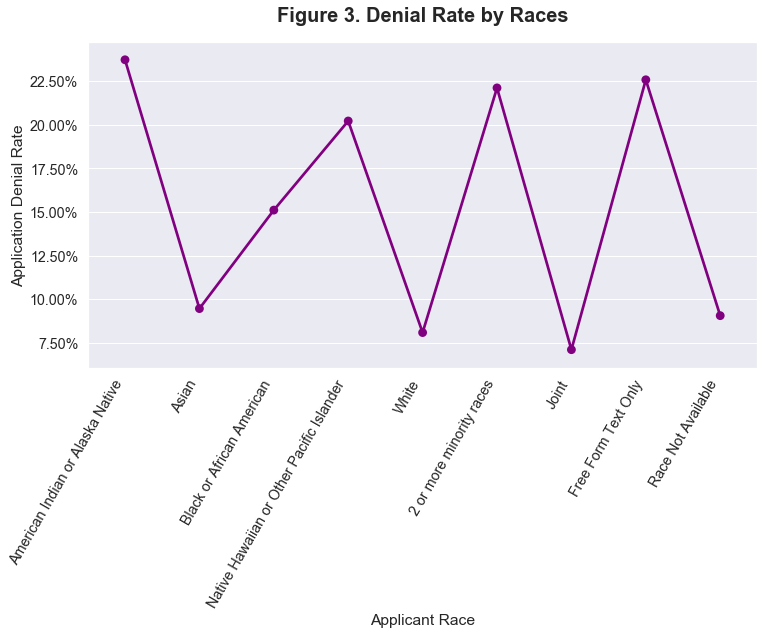

In [14]:
# line plot 
fig, ax = plt.subplots(figsize=(12,6))
race_rate=sns.pointplot(x=table3.index, y='All', data=table3, color='purple')
race_rate.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: "%.2f%%" %(x * 100)))
plt.xticks(rotation=60, ha='right')
plt.xlabel('Applicant Race')
plt.ylabel('Application Denial Rate')
plt.title('Figure 3. Denial Rate by Races', weight='bold', fontsize=20, pad=20)

plt.show()

Frequency of denial reasons for rejected applications

In [15]:
denial_reason_df=pd.DataFrame(subset[subset['loan_status'] == 'Denied'].denial_reason_1.value_counts())
denial_reason_df=denial_reason_df.rename(index={1: 'Debt-to-income ratio', 
                                                2: 'Employment history',
                                                3: 'Credit history',
                                                4: 'Collateral',
                                                5: 'Insufficient cash (downpayment, closing costs)',
                                                6: 'Unverifiable information',
                                                7: 'Credit application incomplete',
                                                8: 'Mortgage insurance denied',
                                                9: 'Other',
                                                1111: 'No info'})
print(denial_reason_df)

                                                denial_reason_1
Debt-to-income ratio                                       9512
Credit history                                             5545
Collateral                                                 5293
Other                                                      2950
Credit application incomplete                              2574
Insufficient cash (downpayment, closing costs)             1599
Unverifiable information                                   1253
No info                                                    1083
Employment history                                          766
Mortgage insurance denied                                    68


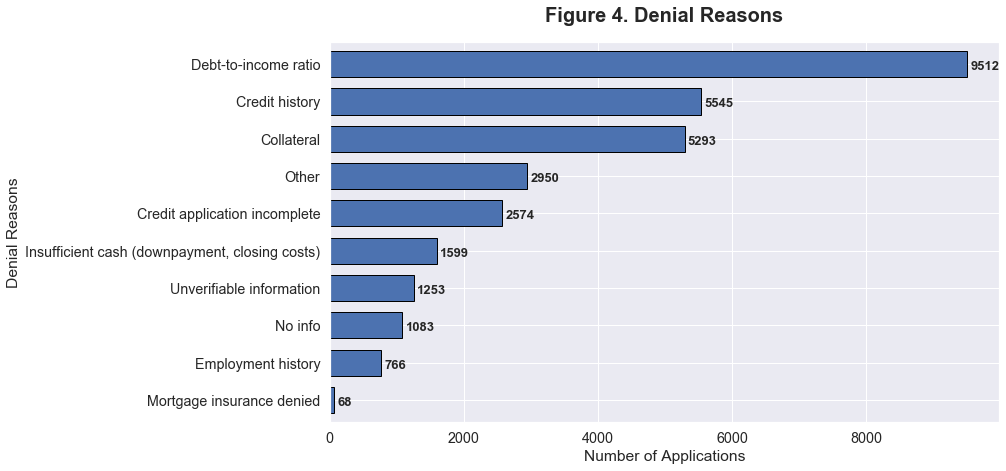

In [16]:
# bar plot
denial_reason_graph=denial_reason_df.plot(kind='barh', figsize=(12,7), edgecolor='black', width=.7)
denial_reason_graph.get_legend().remove()
denial_reason_graph.invert_yaxis() #sort bars in descending order
denial_reason_graph.set(xlabel='Number of Applications', ylabel='Denial Reasons')
# add numbers of applications for each bar
for i in denial_reason_graph.patches:
    denial_reason_graph.text(i.get_width()+50, i.get_y()+0.5, str(round((i.get_width()), 2)), 
                             fontweight='bold', fontsize=13)
plt.title('Figure 4. Denial Reasons', weight='bold', fontsize=20, pad=20)

plt.show()

Denial rate by debt-to-income ratio

In [17]:
# Number of applicants classified by debt/income and state
table4=pd.crosstab(subset.state_code,subset.debt_to_income_ratio,margins=True)
print(table4)

debt_to_income_ratio  20%-<30%  30%-<36%    36    37    38    39     40     41     42    43     44    45    46    47    48     49  50%-60%   <20%  >60%  Exempt     All
state_code                                                                                                                                                             
MA                       11930     12453  2482  2563  2650  2832   2941   2922   3242  2706   2999  2383  2336  2374  2417   3003     5936   2788  1499    6344   78800
ME                        2185      2325   475   541   469   506    631    521    574   527    535   430   372   368   343    424     1175    539   379    2074   15393
NH                        2449      2898   549   575   671   721    688    737    788   728    775   699   642   604   673    771     1738    625   468     718   18517
NY                       21562     22209  4302  4502  4732  4993   5258   5174   5721  4845   5081  4376  4096  4322  4554   5662    11368   5997  3893    4535 

In [18]:
# Number of denied applicants classified by debt/income and state
table5=pd.crosstab(Denied_data.state_code,Denied_data.debt_to_income_ratio,margins=True)
print(table5)

debt_to_income_ratio  20%-<30%  30%-<36%   36   37   38   39   40   41   42   43   44   45   46   47   48   49  50%-60%  <20%  >60%  Exempt    All
state_code                                                                                                                                        
MA                         516       589  125  129  146  141  191  179  183  165  217  173  208  192  207  228     1196   213  1246     499   6743
ME                         166       175   38   56   36   48   57   37   48   47   63   41   41   35   43   41      256    64   287     381   1960
NH                         202       193   49   43   46   51   58   51   43   44   60   59   56   43   61   63      400    68   394      73   2057
NY                        1644      1658  347  345  385  403  454  448  449  461  473  403  454  412  498  541     2883   757  3226     351  16592
RI                         107       122   31   23   29   39   55   31   36   30   37   38   44   48   44   45      29

In [19]:
# Percentage of denied applicants classified by debt/income and state
table6=table5/table4
print(table6)

debt_to_income_ratio  20%-<30%  30%-<36%        36        37        38        39        40        41        42        43        44        45        46        47        48        49   50%-60%      <20%      >60%    Exempt       All
state_code                                                                                                                                                                                                                            
MA                    0.043252  0.047298  0.050363  0.050332  0.055094  0.049788  0.064944  0.061259  0.056447  0.060976  0.072357  0.072598  0.089041  0.080876  0.085643  0.075924  0.201482  0.076399  0.831221  0.078657  0.085571
ME                    0.075973  0.075269  0.080000  0.103512  0.076759  0.094862  0.090333  0.071017  0.083624  0.089184  0.117757  0.095349  0.110215  0.095109  0.125364  0.096698  0.217872  0.118738  0.757256  0.183703  0.127331
NH                    0.082483  0.066598  0.089253  0.074783  0.068554  0.07

In [20]:
# selecting only 'All' row
table6_extract=pd.DataFrame(table6.loc['All'])
table6_extract.drop('All')
table6_extract=table6_extract.reindex(['<20%','20%-<30%','30%-<36%','36','37','38','39','40',
                 '41','42','43','44','45','46','47','48','49','50%-60%',
                 '>60%','Exempt'])
table6_extract=table6_extract.rename(index={'36':'36%','37':'37%','38':'38%','39':'39%','40':'40%',
                 '41':'41%','42':'42%','43':'43%','44':'44%','45':'45%','46':'46%','47':'47%',
                 '48':'48%','49':'49%'})
print(table6_extract)

                           All
debt_to_income_ratio          
<20%                  0.111341
20%-<30%              0.066160
30%-<36%              0.065622
36%                   0.071386
37%                   0.069971
38%                   0.072739
39%                   0.071752
40%                   0.081443
41%                   0.075705
42%                   0.069834
43%                   0.080671
44%                   0.085401
45%                   0.085788
46%                   0.101249
47%                   0.090524
48%                   0.101032
49%                   0.088470
50%-60%               0.230088
>60%                  0.820954
Exempt                0.095539


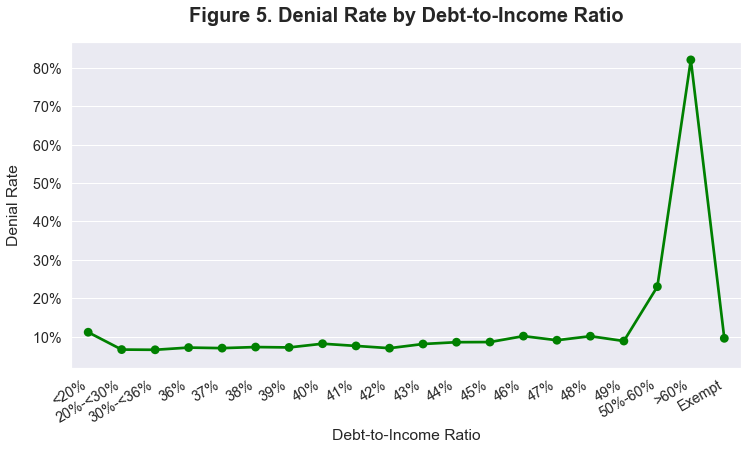

In [21]:
# line plot
fig, ax = plt.subplots(figsize=(12,6))
ratio_rate=sns.pointplot(x=table6_extract.index, y='All', data=table6_extract, color='green')
ratio_rate.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '%4d%%'%(x * 100)))
plt.xticks(rotation=30, ha='right')
plt.xlabel('Debt-to-Income Ratio')
plt.ylabel('Denial Rate')
plt.title('Figure 5. Denial Rate by Debt-to-Income Ratio', weight='bold', fontsize=20, pad=20)

plt.show()

Identify first-time home buyers proportion by loan types

In [22]:
# Number of applications by loan types for both first-time buyers subset and all buyers

loan_type1= df.loan_type.value_counts()/len(df.loan_type)
loan_type2= subset.loan_type.value_counts()/df.loan_type.value_counts()
print(loan_type1)
print(loan_type2)

1    0.835089
2    0.119342
3    0.037960
4    0.007609
Name: loan_type, dtype: float64
1    0.296993
2    0.496572
3    0.407418
4    0.731059
Name: loan_type, dtype: float64


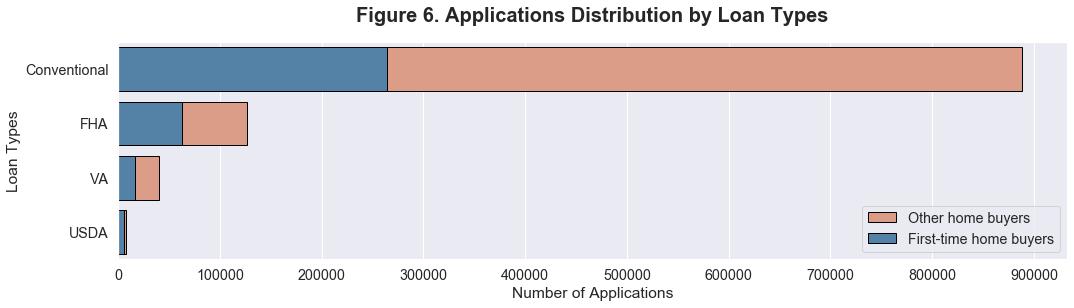

In [23]:
# bar chart
fig, ax = plt.subplots(figsize=(17,4)) #change graph size
all_buyers=sns.countplot(y='loan_type', data=df, color='darksalmon', edgecolor='black')
ft_buyers=sns.countplot(y='loan_type', data=subset, color='steelblue', edgecolor='black')
plt.legend(labels=['Other home buyers', 'First-time home buyers'], loc='lower right')
all_buyers.set_xticks([0,100000,200000,300000,400000,500000,600000,700000,800000,900000])
all_buyers.set_yticklabels(['Conventional', 'FHA','VA','USDA'])
plt.xlabel('Number of Applications')
plt.ylabel('Loan Types')
plt.title('Figure 6. Applications Distribution by Loan Types', weight='bold', fontsize=20, pad=20)
plt.show()

Bootstrap confidence intervals for income, loan amount, property value

In [24]:
# make values in property_value column in thousands of dollars
# to be consistent with income and loan amount
subset['property_value']= subset.property_value/1000

In [25]:
# Draw bootstrap replicates
def draw_bs_reps(data, func,size=1):
    n = len(data)
    reps = np.empty(size)
    for i in range(size):
        bs_sample = np.random.choice(data, n)
        reps[i] = func(bs_sample)     
    return reps

In [26]:
# bootstrap confidence interval of income 
bs_reps_income =draw_bs_reps(subset['income'], np.mean, size=10000)
sem = np.std(subset.income) / np.sqrt(len(subset.income))
print(sem)

conf_int = np.percentile(bs_reps_income,[5,90])
print('90% confidence interval =', conf_int, 'income')

0.3059548940564544
90% confidence interval = [125.92198784 126.80744358] income


In [27]:
# bootstrap confidence interval of loan amount
bs_reps_loan_amount =draw_bs_reps(subset['loan_amount'], np.mean, size=10000)
sem = np.std(subset.loan_amount) / np.sqrt(len(subset.loan_amount))
print(sem)

conf_int = np.percentile(bs_reps_loan_amount,[5,90])
print('90% confidence interval =', conf_int, 'loan_amount')

0.5151992716787435
90% confidence interval = [323.98018436 325.49094654] loan_amount


In [28]:
# exclude nan values for the confidence interval test
subset1=subset[(subset.property_value>0)]

# bootstrap confidence interval of property_value 
bs_reps_property_value =draw_bs_reps(subset1['property_value'], np.mean, size=10000)
sem = np.std(subset1.property_value) / np.sqrt(len(subset1.property_value))
print(sem)

conf_int = np.percentile(bs_reps_property_value,[5,90])
print('90% confidence interval =', conf_int, 'property_value')

1.0060019567439094
90% confidence interval = [423.37342373 426.29077571] property_value


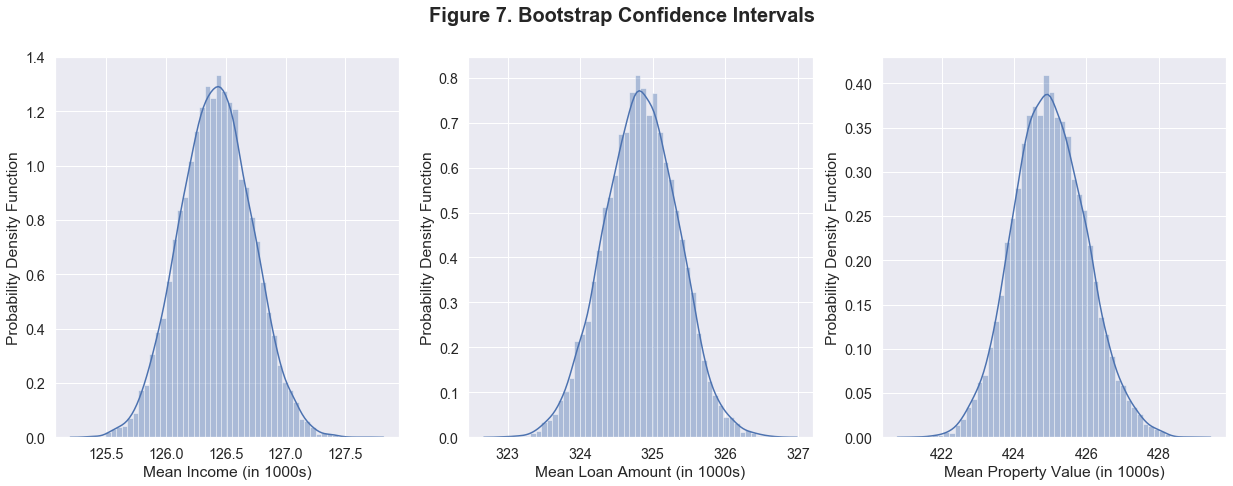

In [29]:
# histogram plots
fig=plt.figure(figsize=(21,7))

plt.subplot(1,3,1)
inc_ci= sns.distplot(bs_reps_income)
inc_ci.set(xlabel='Mean Income (in 1000s)', ylabel='Probability Density Function')

plt.subplot(1,3,2)
loan_ci= sns.distplot(bs_reps_loan_amount)
loan_ci.set(xlabel='Mean Loan Amount (in 1000s)', ylabel='Probability Density Function')

plt.subplot(1,3,3)
value_ci= sns.distplot(bs_reps_property_value)
value_ci.set(xlabel='Mean Property Value (in 1000s)', ylabel='Probability Density Function')

fig.suptitle('Figure 7. Bootstrap Confidence Intervals', fontweight='bold', fontsize=20)
plt.show()

Logistic Regresion Model

In [30]:
# Change age to numeric data
def age (row):
    if (row.applicant_age == '25-34'): 
        return 30
    elif (row.applicant_age == '35-44'):
        return 40
    elif (row.applicant_age == '45-54'):
        return 50
    elif (row.applicant_age == '55-64'):
        return 60
    elif (row.applicant_age == '65-74'):
        return 70
    elif (row.applicant_age == '<25'):
        return 22
    elif (row.applicant_age == '>74'):
        return 79

subset['applicant_age']=subset.apply(age,axis=1)
print(subset.applicant_age.unique())

[30. 40. 50. 60. 22. nan]


In [32]:
print(subset.debt_to_income_ratio.unique())

['41' '30%-<36%' '45' '>60%' '47' '50%-60%' '39' '48' '44' nan '37'
 '20%-<30%' '42' '43' '46' '49' '36' '40' '38' '<20%' 'Exempt']


In [34]:
# Change string of debt_to_income_ratio to numeric data
subset=subset.replace('<20%',10).replace('20%-<30%',25).replace('30%-<36%',33).replace('50%-60%',55).replace('>60%',70)
print(subset.debt_to_income_ratio.unique())

['41' 33 '45' 70 '47' 55 '39' '48' '44' nan '37' 25 '42' '43' '46' '49'
 '36' '40' '38' 10 'Exempt']


In [35]:
# Create new dataframe that include only variables for regression model
regressiondata=subset[['loan_status','income', 'loan_amount','applicant_age','debt_to_income_ratio']]
print(regressiondata.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 349093 entries, 0 to 1063315
Data columns (total 5 columns):
loan_status             306877 non-null object
income                  349093 non-null float64
loan_amount             349093 non-null float64
applicant_age           339082 non-null float64
debt_to_income_ratio    268564 non-null object
dtypes: float64(3), object(2)
memory usage: 26.0+ MB
None


In [37]:
# Remove not avaible values and nan values
regressiondata=regressiondata.replace('Exempt',None)
subset=subset.replace('Race Not Available',None).replace('Sex Not Available',None)
regressiondata.dropna(axis=0, how='any', inplace=True)
print(regressiondata.info())
print(regressiondata.applicant_age.unique())
print(subset.derived_sex.unique())
print(subset.derived_race.unique())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263043 entries, 0 to 1063315
Data columns (total 5 columns):
loan_status             263043 non-null object
income                  263043 non-null float64
loan_amount             263043 non-null float64
applicant_age           263043 non-null float64
debt_to_income_ratio    263043 non-null object
dtypes: float64(3), object(2)
memory usage: 12.0+ MB
None
[30. 40. 50. 60. 22.]
['Male' 'Female' 'Joint']
['Asian' 'White' 'Native Hawaiian or Other Pacific Islander'
 'Black or African American' 'American Indian or Alaska Native'
 '2 or more minority races' 'Joint' 'Free Form Text Only']


In [38]:
regressiondata[['debt_to_income_ratio']]=regressiondata[['debt_to_income_ratio']].astype(int)

# Create dummy variables
dummyrace = pd.get_dummies(subset['derived_race'], prefix='race') 
dummytype = pd.get_dummies(subset['loan_type'],prefix='type')
dummygender = pd.get_dummies(subset['derived_sex'])

# Create regression data
regressiondata=regressiondata.join(dummyrace.loc[:,'race_Asian':]).join(dummytype.loc[:,'type_2':]).join(dummygender.loc[:,'Joint':])

#Insert Intercept
regressiondata['intercept'] = 1.0

# X value
train_cols = regressiondata.columns[1:]

# Y value
regressiondata.loc[regressiondata['loan_status'] == 'Approved','loan_status'] = 1
regressiondata.loc[regressiondata['loan_status'] == 'Denied','loan_status'] = 0

# Create regression model
logit = sm.Logit(regressiondata['loan_status'].astype(float), regressiondata[train_cols].astype(float))

# fit the model
result = logit.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.313270
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:            loan_status   No. Observations:               263043
Model:                          Logit   Df Residuals:                   263027
Method:                           MLE   Df Model:                           15
Date:                Sun, 12 Apr 2020   Pseudo R-squ.:                 0.09324
Time:                        18:27:24   Log-Likelihood:                -82404.
converged:                       True   LL-Null:                       -90877.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
income                              

C:\Users\linhv\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy:  0.8977509466096927


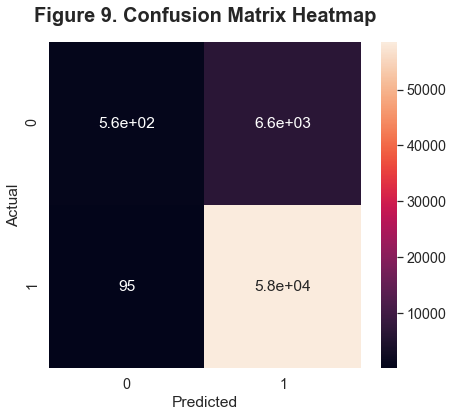

In [43]:
# Test the model
X_train, X_test, y_train, y_test = train_test_split(regressiondata[train_cols],regressiondata['loan_status'], test_size=0.25, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

# Creat confusion matrix
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
plt.figure(figsize=(7,6))
sns.heatmap(confusion_matrix, annot=True)

print('Accuracy: ',metrics.accuracy_score(y_test, y_pred))
plt.title('Figure 9. Confusion Matrix Heatmap', weight='bold', fontsize=20, pad=20)
plt.show()


In [44]:
# Create confidence interval
params = result.params
conf = result.conf_int()
conf['OR'] = params
conf.columns = ['2.5%', '97.5%', 'OR']
print(np.exp(conf))

                                                     2.5%      97.5%         OR
income                                           0.999340   0.999517   0.999428
loan_amount                                      1.000748   1.000883   1.000815
applicant_age                                    0.985814   0.988223   0.987018
debt_to_income_ratio                             0.931258   0.933583   0.932419
race_Asian                                       1.863866   2.508613   2.162341
race_Black or African American                   1.410877   1.899518   1.637066
race_Free Form Text Only                         0.375641   2.698802   1.006867
race_Joint                                       1.784366   2.508967   2.115872
race_Native Hawaiian or Other Pacific Islander   0.941594   1.552208   1.208946
race_White                                       2.265790   3.018899   2.615376
type_2                                           1.279937   1.367514   1.323001
type_3                                  

In [ ]:
jupyter nbconvert –to pdf file_name.ipynb